Last update: May 13th, 2024 

# Oblique whistler Linear Theory QLT 

#### V. Roytershteyn and G. L. Delzanno. *Nonlinear coupling of whistler waves to oblique electrostatic turbulence enabled by cold plasma*. Physics of Plasmas, 28(4):042903, 04 2021

Author: Opal Issan (oissan@ucsd.edu)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import wofz 
import scipy
from scipy.sparse import diags

In [2]:
%matplotlib inline
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

In [3]:
# important basic functions 

def Z(z):
    # plasma dispersion function Z(xi)
    return 1j * np.sqrt(np.pi) * wofz(z)
    
def Z_prime(z):
    # derivative of the plasma dispersion function Z'(xi)
    return -2*(1+z*Z(z))

def I(Lambda_e, m):
    # modified Bessel function of the first kind I_{m}(\lambda) x exp(-lambda)
    return scipy.special.ive(m, Lambda_e)

def J(Lambda_e, m):
    # Bessel function of the first kind J_{m}(\lambda)
    return scipy.special.jv(m, Lambda_e)

### Oblique electrostatic waves
The dispersion relation is 
\begin{equation*}
    k_{\perp}^2 + k_{\|}^2 + \frac{2\omega_{pc}^2}{\alpha_{\| c}^2} \left[ 1 +   \sum_{n=-\infty}^{\infty} \exp(-\lambda_{c}) I_{n}(\lambda_{c}) Z(\xi_{c}^{n}) \left[\xi_{c}^{0} +  \frac{n \Omega_{ce}}{k_{\|} \alpha_{\| c}} \left[ 1-\frac{T_{\| c}}{T_{\perp c}} \right]\right]\right] = \frac{\omega_{pi}^2}{\alpha_{i}^2} \left|J_{1}\left(\frac{k_{\perp} |V_{Dc}|}{\omega_{0}}\right)\right|^2 Z'\left(\frac{\omega -\omega_{0}}{k \alpha_{i}}\right).
\end{equation*}
\begin{align*}
    k &\coloneqq \|\vec{k}\|_{2} = \sqrt{k_{\perp}^2 + k_{\|}^2}\\
    \lambda_{c} &\coloneqq \frac{k_{\perp}^2 \alpha_{\|c}^2}{2} \\
    \xi_{c}^{n} &\coloneqq \frac{\omega + n \Omega_{ce}}{k_{\|} \alpha_{\|c}}
\end{align*} 

In [14]:
# parameters from 2021 paper 
# normalization (vadim parameters)
# time is normalized to the electron cyclotron frequency 1/Omega_ce
# space is normalized to electron inertial length d_e
omega_0 = 0.5 # Omega_ce
omega_pe = 4 # Omgea_{ce}

n_c = 4/5 # n^e_0

# thermal velocity 
alpha_c = 0.0079  # / np.sqrt(2) # d_e x Omega_ce
alpha_i =  alpha_c / np.sqrt(1836) # d_e x Omega_ce

v_0 = 0.65 * alpha_c #* np.sqrt(2) # d_e x Omega_ce
omega_pi = omega_pe / np.sqrt(1836) # Omega_ce

In [15]:
def sum_bessel(lambda_, omega, kz, n_max, alpha_c):
    res = 0 
    for n in range(-n_max, n_max+1):
        xi = (omega + n)/(kz*alpha_c)
        res +=  I(m=n, Lambda_e=lambda_)* Z(z=xi) 
    return res

def electron_response(n_c, omega_pe, alpha_c, omega, kz, n_max, ky):
    # Bessel argument electron
    lambda_ = 0.5 * ((ky*alpha_c)**2)
    return 2 * n_c *((omega_pe**2)/(alpha_c**2)) * (1 + (omega / (kz*alpha_c)) * sum_bessel(lambda_=lambda_, omega=omega, kz=kz, 
                                                                                           n_max=n_max, alpha_c=alpha_c))

def ion_response(omega_pi, alpha_i, m_star, ky, v_0, omega_0, omega, kz):
    k_abs = np.sqrt(ky**2 + kz**2)
    # Bessel argument ion Doppler-shifted
    a = ky * np.abs(v_0) / omega_0
    return (omega_pi**2)/(alpha_i**2) * (J(m=m_star, Lambda_e=a)**2) * Z_prime(z=(omega - omega_0)/(alpha_i * k_abs))
    
def disp_k(ky, 
           kz, 
           omega_pe=omega_pe, 
           omega_pi=omega_pi, 
           omega_0=omega_0,
           v_0=v_0, 
           alpha_i=alpha_i,
           alpha_c=alpha_c, 
           n_c=n_c, 
           m_star=-1,
           n_max=20):
    return lambda omega : ky**2 + kz**2\
    + electron_response(n_c=n_c, omega_pe=omega_pe, alpha_c=alpha_c, omega=omega, kz=kz, ky=ky, n_max=n_max)\
    - ion_response(omega_pi=omega_pi, alpha_i=alpha_i, m_star=m_star, ky=ky, v_0=v_0, omega_0=omega_0, omega=omega, kz=kz)

In [16]:
ky = 6
kz = ky*np.sqrt((omega_0**2)/ (1-omega_0**2))
print("k = ", np.sqrt(ky**2 + kz**2))

sol = scipy.optimize.newton(disp_k(ky=ky, kz=kz), omega_0+1e-3j, tol=1e-15)

print("omega_k + i gamma = ", sol)
print("dispersion residual = ", abs(disp_k(ky=ky, kz=kz)(sol)))

k =  6.928203230275509
omega_k + i gamma =  (0.48718183113828956+1.7749059819848618e-16j)
dispersion residual =  3.902324488316232e-11


In [17]:
ky_ = np.linspace(5, 60, 80)
kz_ = np.sqrt((omega_0**2) / (1-omega_0**2))*ky_
sol_ = np.zeros((len(ky_)), dtype="complex128")
k_abs = np.zeros((len(ky_)))

In [18]:
for ii in range(len(ky_)):
    try:
        k_abs[ii] = np.sqrt(ky_[ii]**2 + kz_[ii]**2)
        sol_[ii] = scipy.optimize.newton(disp_k(ky=ky_[ii], kz=kz_[ii]), omega_0 + 1e-4j, tol=1e-15)
        print("dispersion residual = ", abs(disp_k(ky=ky_[ii], kz=kz_[ii])(sol_[ii])))
        if abs(disp_k(ky=ky_[ii], kz=kz_[ii])(sol_[ii])) > 1e-8:
            sol_[ii] =  np.inf + np.inf*1j
    except:
        sol_[ii] =  np.inf + np.inf*1j
        print("An exception occurred")

dispersion residual =  1.3315249283447781e-11
dispersion residual =  2.4123921456684935e-11
dispersion residual =  3.9971316880069206e-11
dispersion residual =  1.411851093077451e-11
dispersion residual =  9.160850553067572e-11
dispersion residual =  8.548362019312688e-11
dispersion residual =  1.2780144707185827e-11
dispersion residual =  6.970990077747471e-12
dispersion residual =  8.997641071321885e-11
dispersion residual =  2.0117030944063264e-11
dispersion residual =  8.60084944782749e-11
dispersion residual =  3.4937397877911775e-11
dispersion residual =  5.50574363057466e-11
dispersion residual =  2.9074150510727484e-10
dispersion residual =  3.5529752182937874e-09
dispersion residual =  3.362110573977834e-10
dispersion residual =  3.2951295790311554e-10
dispersion residual =  5.887919275503149e-10
dispersion residual =  1.070492894717597e-09
dispersion residual =  4.404964490265355e-09
dispersion residual =  6.189796083297311e-10
dispersion residual =  3.3381503295765307e-10
di

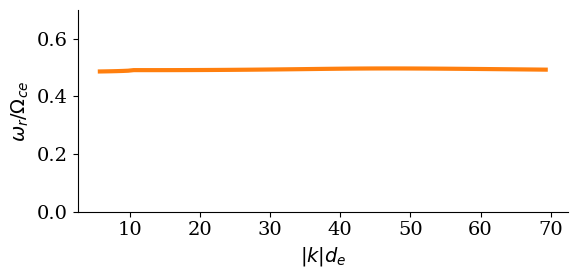

In [19]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(k_abs, sol_.real, linewidth=3, color="tab:orange")
ax.set_ylabel('$\omega_r/\Omega_{ce}$')
ax.set_xlabel('$|k|d_{e}$')
ax.set_ylim(0, 0.7)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig("figs/vadim_2021/vadim_fig5_c.png", dpi=300, bbox_inches='tight')

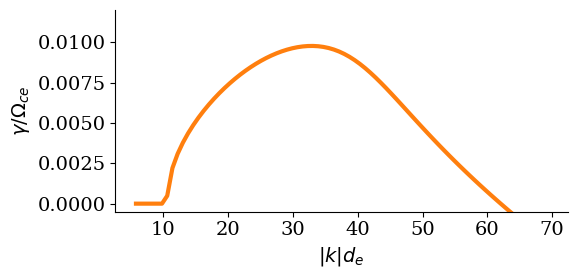

In [20]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(k_abs, sol_.imag, color="tab:orange", linewidth=3)
ax.set_ylabel('$\gamma/\Omega_{ce}$', rotation=90)
ax.set_xlabel('$|k|d_{e}$')
ax.set_ylim(-0.0005, 0.012)
#ax.set_xticks([180, 200, 220, 240])
#ax.set_yticks([0, 0.0025, 0.005, 0.0075])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig("figs/vadim_2021/vadim_fig5_d.png", dpi=300, bbox_inches='tight')

# QLT equations
\begin{align*}
    \frac{\mathrm{d} K_{\perp c}}{\mathrm{d} t} &= \frac{n_{c}}{2\pi}  \frac{\omega_{pe}^2}{\alpha_{\| c}^2} \int \mathrm{d} \vec{k} \frac{\mathcal{E}_{E}(k_{\perp}, t)}{|\vec{k}|^2} \mathrm{Im}\left\{\sum_{n=-\infty}^{\infty} n \exp(-\lambda_{c})  I_{n}(\lambda_{c}) \left[\xi_{c}^{0} + \frac{n}{k_{\|} \alpha_{\| c} } \left[\frac{\alpha_{\| c}^2}{\alpha_{\perp c}^2} - 1\right] \right] Z(\xi_{c}^{n})\right\}\\
    \frac{\mathrm{d} K_{\| c}}{\mathrm{d} t} &=\frac{n_{c}}{\pi}  \frac{\omega_{pe}^2}{\alpha_{\| c}^2} \int \mathrm{d} \vec{k} \frac{\mathcal{E}_{E}(k_{\perp}, t)}{|\vec{k}|^2}\mathrm{Im} \left\{\omega +  \sum_{n=-\infty}^{\infty} \exp(-\lambda_{c}) I_{n}(\lambda_{c}) \left\{\omega  + n \left[\frac{\alpha_{\| c}^2}{\alpha_{\perp c}^2} - 1\right]   \right] \xi_{c}^{n}Z(\xi_{c}^{n}) \right\}\\
    \frac{\mathrm{d} T_{\perp c}}{\mathrm{d} t} &= \frac{\omega_{pe}^2}{ 2\sqrt{\pi} \alpha_{\| c}^2} \int \mathrm{d} \vec{k} \frac{\mathcal{E}_{E}(k_{\perp}, t)}{|\vec{k}|^2}   \sum_{n=-\infty}^{\infty} n \exp(-\lambda_{c}) I_{n}(\lambda_{c})\left[\mathrm{Re}\{\xi_{c}^{0}\} + \frac{n}{k_{\|} \alpha_{\| c}} \left[\frac{\alpha_{\| c}^2}{\alpha_{\perp c}^2} -1 \right] \right] \exp\left(-\mathrm{Re}\{\xi_{c}^{n}\}^2 \right) \\
    \frac{\mathrm{d} T_{\| c}}{\mathrm{d} t} &= \frac{\omega_{pe}^2}{\sqrt{\pi} \alpha_{\| c}^2} \int \mathrm{d} \vec{k} \frac{\mathcal{E}_{E}(k_{\perp}, t)}{|\vec{k}|^2} \sum_{n=-\infty}^{\infty} \exp(-\lambda_{c}) I_{n}(\lambda_{c}) \left[ \mathrm{Re}\{\omega\} + n \left[\frac{\alpha_{\| c}^2 }{\alpha_{\perp c}^2 } -1\right] \right] \mathrm{Re}\{\xi_{c}^{n}\} \exp\left(-\mathrm{Re}\{\xi_{c}^{n}\}^2 \right) \\
    \partial_{t} \mathcal{E}_{E}(k_{\perp}, t)  &= 2 \mathrm{Im}\{\omega\}  \mathcal{E}_{E}(k_{\perp}, t) \\
    \partial_{t} \int_{0}^{\infty} \mathrm{d} k_{\|}  \mathcal{E}_{B}(k_{\|}, t) &= \frac{4\pi}{\frac{\omega_{0}^2}{k_{\|0}^2 \omega_{pe}^2} + 1} \left[ -\frac{\mathrm{d} K_{\perp c}}{\mathrm{d} t} - \frac{\mathrm{d} K_{\| c}}{\mathrm{d} t} - \frac{1}{2\pi} \int_{0}^{\infty} \mathrm{d} k_{\perp} \mathrm{Im} \{ \omega\} \mathcal{E}_{E}(k_{\perp}, t) \right]\\
    \frac{\mathrm{d} |V_{Dc}(t)|^2}{\mathrm{d} t} &= \frac{1}{4\pi} \left[\frac{\omega_{0}}{k_{\|0}}\frac{1}{\omega_{0} -1} \right]^2 \partial_{t} \int_{0}^{\infty} \mathrm{d} k_{\|}  \mathcal{E}_{B}(k_{\|}, t)\\
    |\vec{k}|^2 + 2 n_{c} \frac{\omega_{pe}^2}{\alpha_{\| c}^2} &\left[ 1 +   \sum_{n=-\infty}^{\infty} \exp(-\lambda_{c}) I_{n}(\lambda_{c}) Z(\xi_{c}^{n}) \left[\xi_{c}^{0} + \frac{n}{k_{\|} \alpha_{\| c}} \left[\frac{\alpha_{\| c}^2}{\alpha_{\perp c}^2} -1\right]\right]\right] = \frac{\omega_{pi}^2}{\alpha_{i}^2} \left|J_{1}\left(\frac{k_{\perp} |V_{Dc}|}{\omega_{0}}\right)\right|^2 Z'\left(\frac{\omega -\omega_{0}}{k \alpha_{i}}\right)\\
    \lambda_{c} &\coloneqq \frac{k_{\perp}^2 \alpha_{\perp c}^2}{2} \\
    \xi_{c}^{n} &\coloneqq \frac{\omega - n}{k_{\|} \alpha_{c\|}}
\end{align*}


In [ ]:
def dK_perp_dt():

def dK_par_dt():

def dT_perp_dt():

def dT_par_dt():

def dEdt(gamma, E_vec):
    return 2 * gamma * E_vec

def dBdt():


def dVdt()
